In [1]:
import pandas as pd
import configparser
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', palette='hls')

config = configparser.ConfigParser()
config.read('config.ini')
db_file = config['sqlite']['db_file']
engine = create_engine(f"sqlite:///{db_file}")

In [2]:
student_info = pd.read_sql_table('studentInfo', engine)
student_assessment = pd.read_sql_table('studentAssessment', engine)
student_vle = pd.read_sql_table('studentVle', engine)
courses = pd.read_sql_table('courses', engine)
assessments = pd.read_sql_table('assessments', engine)
vle = pd.read_sql_table('vle', engine)
student_registration = pd.read_sql_table('studentRegistration', engine)

In [3]:
df_vle_agg = (
    student_vle
    .groupby(['code_module','code_presentation','id_student'])['sum_click']
    .sum()
    .reset_index()
)
df = pd.merge(
    student_info,
    df_vle_agg,
    on=['code_module','code_presentation','id_student'],
    how='left'
)
df['sum_click'] = df['sum_click'].fillna(0)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

print("Shape del DataFrame:", df.shape)
print("\nTipos de datos:\n", df.dtypes)
print("\nDescripción estadística (numéricas):\n", df.describe())
print("\nDescripción estadística (categóricas):\n", df.describe(include=['object']))

Shape del DataFrame: (32593, 13)

Tipos de datos:
 code_module              object
code_presentation        object
id_student                int64
gender                   object
region                   object
highest_education        object
imd_band                 object
age_band                 object
num_of_prev_attempts      int64
studied_credits           int64
disability               object
final_result             object
sum_click               float64
dtype: object

Descripción estadística (numéricas):
          id_student  num_of_prev_attempts  studied_credits     sum_click
count  3.259300e+04          32593.000000     32593.000000  32593.000000
mean   7.066877e+05              0.163225        79.758691   1215.141257
std    5.491673e+05              0.479758        41.071900   1692.604449
min    3.733000e+03              0.000000        30.000000      0.000000
25%    5.085730e+05              0.000000        60.000000    142.000000
50%    5.903100e+05              0.000000 

<h3><strong></h3></strong>

<p>

<h3><strong></h3></strong>

<p>

In [19]:
df.describe(include=['object'])

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,disability,final_result
count,32593,32593,32593,32593,32593,31482,32593,32593,32593
unique,7,4,2,13,5,10,3,2,4
top,BBB,2014J,M,Scotland,A Level or Equivalent,20-30%,0-35,N,Pass
freq,7909,11260,17875,3446,14045,3654,22944,29429,12361


<h3><strong></h3></strong>

<p>

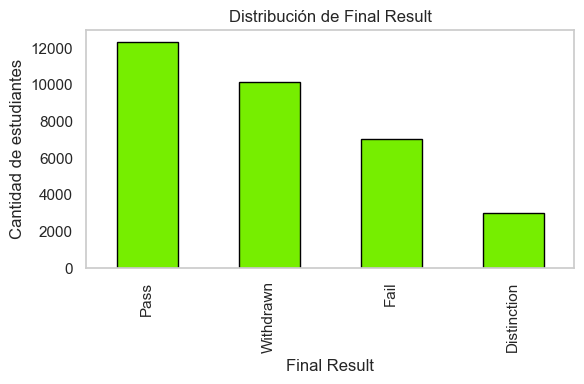

In [5]:
plt.figure(figsize=(6,4))
df['final_result'].value_counts().plot(
    kind='bar',
    color='#76EE00',
    edgecolor='black'
)
plt.title("Distribución de Final Result")
plt.xlabel("Final Result")
plt.ylabel("Cantidad de estudiantes")
plt.grid(False)
plt.tight_layout()
plt.show()

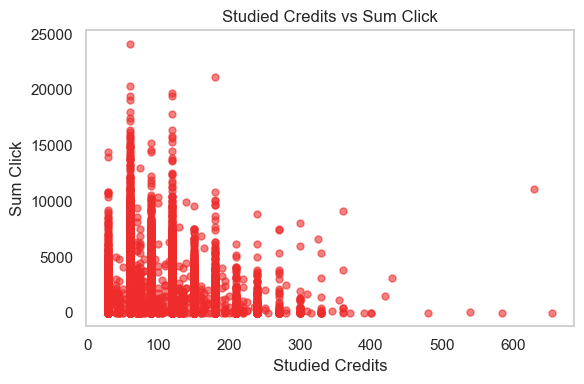

In [6]:
plt.figure(figsize=(6,4))
plt.scatter(
    df['studied_credits'],
    df['sum_click'],
    alpha=0.6,
    s=25,
    color='#EE2C2C'
)
plt.title("Studied Credits vs Sum Click")
plt.xlabel("Studied Credits")
plt.ylabel("Sum Click")
plt.grid(False)
plt.tight_layout()
plt.show()

<Figure size 600x400 with 0 Axes>

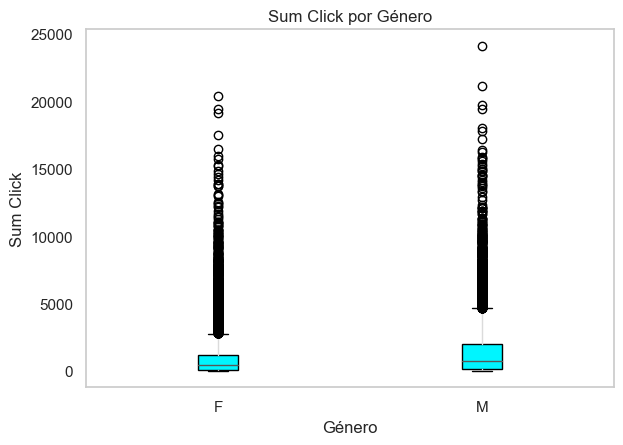

In [7]:
plt.figure(figsize=(6,4))
df.boxplot(
    column='sum_click',
    by='gender',
    patch_artist=True,
    boxprops=dict(facecolor='#00F5FF', edgecolor='black'),
    grid=False
)
plt.title("Sum Click por Género")
plt.suptitle("")
plt.xlabel("Género")
plt.ylabel("Sum Click")
plt.tight_layout()
plt.show()

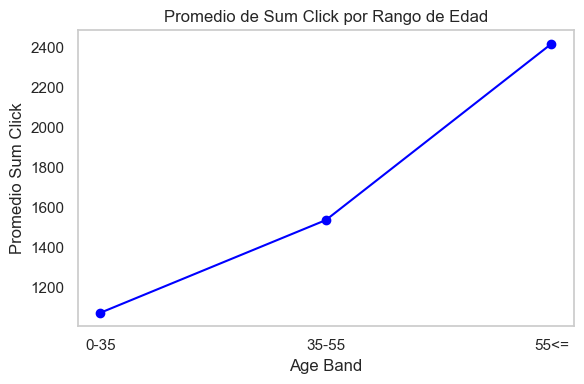

In [8]:
plt.figure(figsize=(6,4))
age_order = ['0-35','35-55','55<=']
avg_click = df.groupby('age_band')['sum_click'].mean().reindex(age_order)
plt.plot(
    avg_click.index,
    avg_click.values,
    marker='o',
    linestyle='-',
    color='#0000FF'
)
plt.title("Promedio de Sum Click por Rango de Edad")
plt.xlabel("Age Band")
plt.ylabel("Promedio Sum Click")
plt.grid(False)
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report
)
from scipy.stats import randint, uniform

df_vle_agg = (
    student_vle
    .groupby(['code_module','code_presentation','id_student'])['sum_click']
    .sum()
    .reset_index()
)

df = pd.merge(
    student_info,
    df_vle_agg,
    on=['code_module','code_presentation','id_student'],
    how='left'
)
df['sum_click'] = df['sum_click'].fillna(0)

cat_cols = ['highest_education','imd_band','age_band','gender']
num_col = 'sum_click'
X_cat_all = df[cat_cols]
X_num_all = df[[num_col]].to_numpy()
y_all = df['final_result']

In [10]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat_enc = ohe.fit_transform(X_cat_all)

X_all = np.hstack([X_cat_enc, X_num_all])

X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

models = {
    'LogReg':       LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradBoost':    GradientBoostingClassifier(random_state=42),
}

param_dists = {
    'LogReg': {
        'C':       uniform(0.01, 10),
        'penalty': ['l2'],
        'solver':  ['lbfgs']
    },
    'RandomForest': {
        'n_estimators':      randint(50, 300),
        'max_depth':         randint(3, 20),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf':  randint(1, 10),
        'max_features':      ['sqrt','log2',None]
    },
    'GradBoost': {
        'n_estimators': randint(50, 200),
        'learning_rate': uniform(0.01, 0.5),
        'max_depth':     randint(2, 10),
        'subsample':     uniform(0.5, 0.5),
        'max_features':  ['sqrt','log2',None]
    }
}

def tune_model(name, estimator, param_dist):
    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        n_iter=30,
        scoring='f1_weighted',
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    search.fit(X_tr, y_tr)
    print(f"Best params for {name}: {search.best_params_}")
    return search.best_estimator_

best_models = {}
for name, base_clf in models.items():
    best = tune_model(name, base_clf, param_dists[name])
    best_models[name] = best

c:\Users\artla\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best params for LogReg: {'C': 4.5706998421703595, 'penalty': 'l2', 'solver': 'lbfgs'}
Best params for RandomForest: {'max_depth': 13, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 212}
Best params for GradBoost: {'learning_rate': 0.05770505824520566, 'max_depth': 8, 'max_features': None, 'n_estimators': 111, 'subsample': 0.6625916610133735}



Classification report for LogReg:
              precision    recall  f1-score   support

 Distinction       0.54      0.02      0.05       605
        Fail       0.30      0.04      0.08      1411
        Pass       0.61      0.77      0.68      2472
   Withdrawn       0.55      0.85      0.66      2031

    accuracy                           0.57      6519
   macro avg       0.50      0.42      0.37      6519
weighted avg       0.52      0.57      0.49      6519



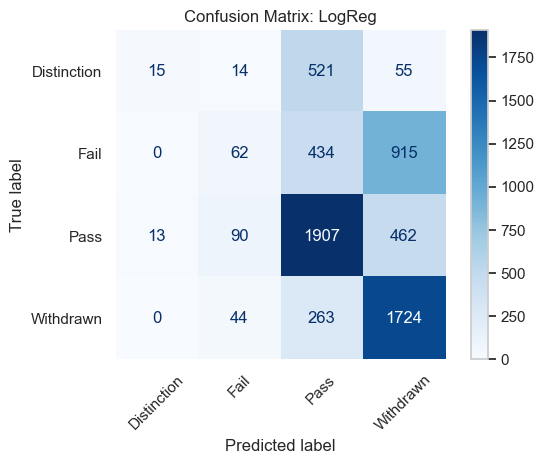


Classification report for RandomForest:
              precision    recall  f1-score   support

 Distinction       0.49      0.04      0.07       605
        Fail       0.37      0.18      0.24      1411
        Pass       0.58      0.87      0.70      2472
   Withdrawn       0.64      0.65      0.65      2031

    accuracy                           0.58      6519
   macro avg       0.52      0.44      0.41      6519
weighted avg       0.55      0.58      0.53      6519



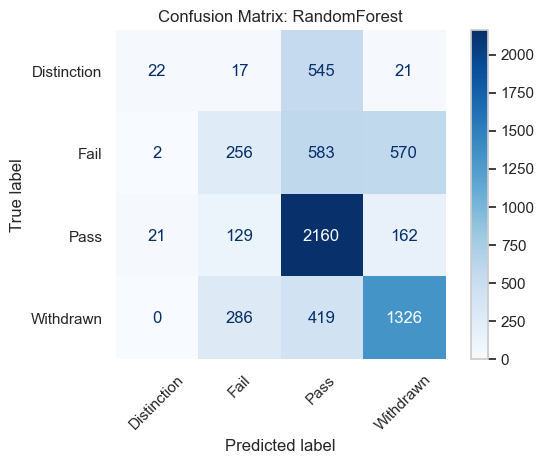


Classification report for GradBoost:
              precision    recall  f1-score   support

 Distinction       0.39      0.07      0.12       605
        Fail       0.36      0.19      0.25      1411
        Pass       0.58      0.85      0.69      2472
   Withdrawn       0.64      0.64      0.64      2031

    accuracy                           0.57      6519
   macro avg       0.49      0.44      0.43      6519
weighted avg       0.54      0.57      0.53      6519



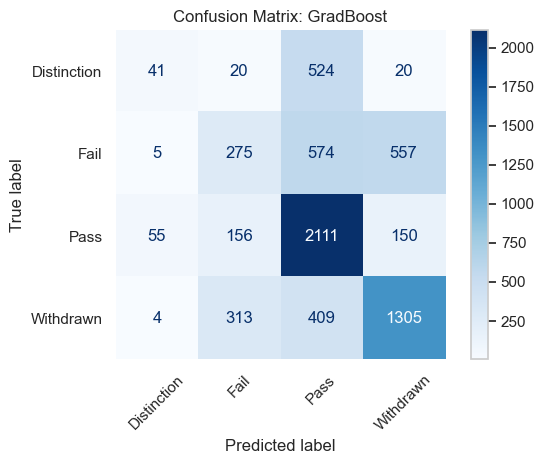

In [11]:
metrics_list = []

for name, clf in best_models.items():
    y_pred  = clf.predict(X_te)
    y_proba = clf.predict_proba(X_te)
    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average='weighted', zero_division=0)
    rec  = recall_score(y_te, y_pred, average='weighted')
    f1   = f1_score(y_te, y_pred, average='weighted')
    roc  = roc_auc_score(pd.get_dummies(y_te), y_proba, average='weighted', multi_class='ovr')
    
    metrics_list.append({
        'Model':    name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall':   rec,
        'F1-score': f1,
        'ROC AUC':  roc
    })
    
    print(f"\nClassification report for {name}:")
    print(classification_report(y_te, y_pred))

    disp = ConfusionMatrixDisplay.from_predictions(
    y_te, y_pred,
    display_labels=clf.classes_,
    cmap='Blues',
    normalize=None
    )

    ax = disp.ax_
    ax.set_title(f'Confusion Matrix: {name}')
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [12]:
metrics_df = pd.DataFrame(metrics_list).set_index('Model')
print("\n=== Tabla final de métricas tras tuning ===")
print(metrics_df)


=== Tabla final de métricas tras tuning ===
              Accuracy  Precision    Recall  F1-score   ROC AUC
Model                                                          
LogReg        0.568799   0.515211  0.568799  0.486456  0.777762
RandomForest  0.577389   0.545571  0.577389  0.525223  0.787848
GradBoost     0.572480   0.535485  0.572480  0.528473  0.786640


In [20]:
metrics_df

,Accuracy,Precision,Recall,F1-score,ROC AUC
Model,,,,,
LogReg,0.568799,0.515211,0.568799,0.486456,0.777762
RandomForest,0.577389,0.545571,0.577389,0.525223,0.787848
GradBoost,0.572480,0.535485,0.572480,0.528473,0.786640


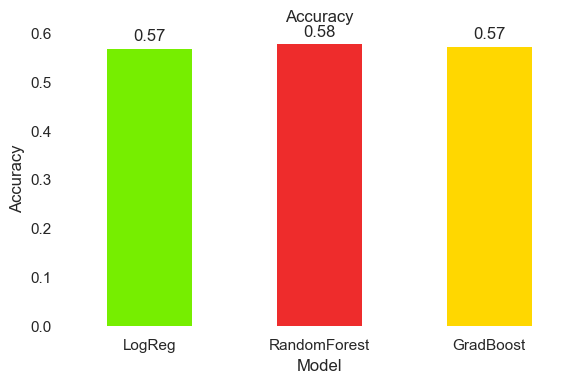

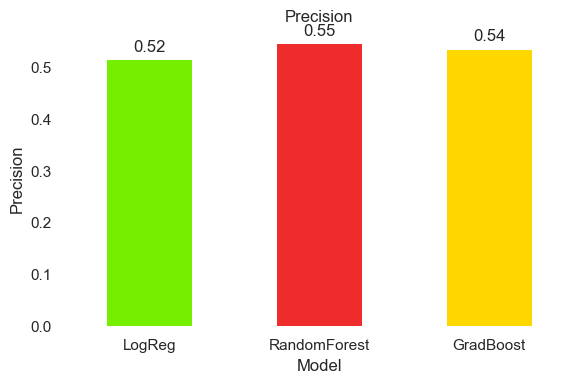

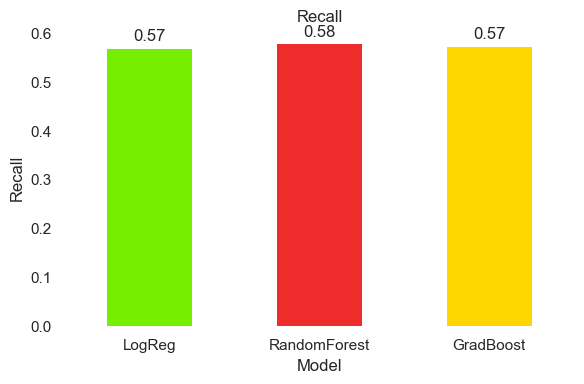

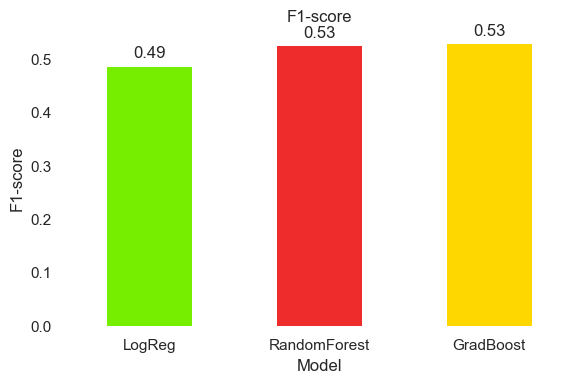

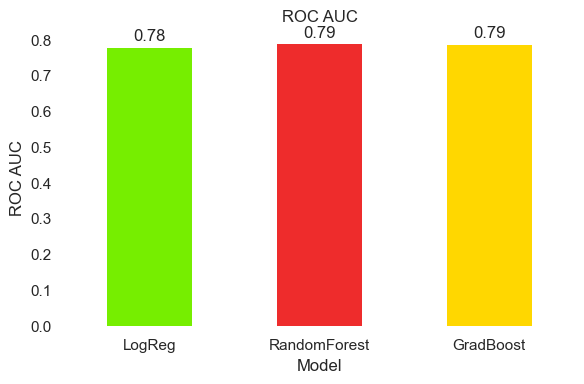

In [13]:
colors = ['#76EE00', '#EE2C2C', '#FFD700']

for metric in metrics_df.columns:
    plt.figure(figsize=(6,4))
    ax = metrics_df[metric].plot(
        kind='bar',
        color=colors,
        edgecolor='none'
    )

    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xlabel('Model')
    ax.set_xticklabels(metrics_df.index, rotation=0)

    ax.grid(False)
    ax.set_facecolor('white')

    for spine in ['top','right','left','bottom']:
        ax.spines[spine].set_visible(False)

    for i, v in enumerate(metrics_df[metric]):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

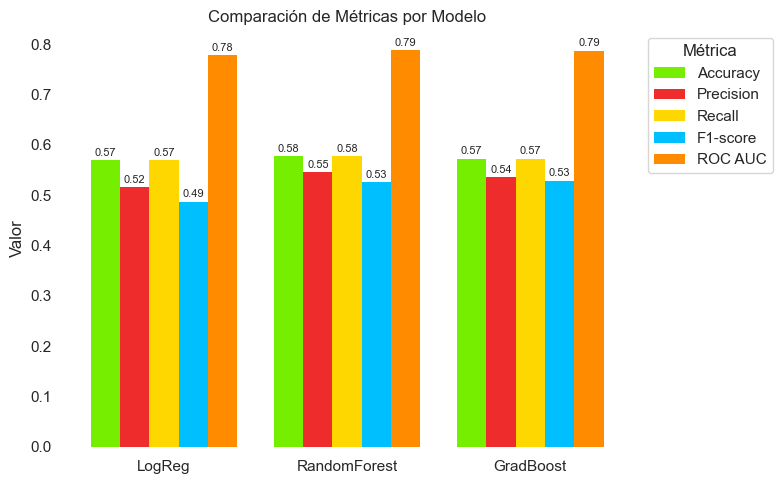

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que metrics_df ya está definido y tiene índices ['LogReg','RandomForest','GradBoost']
# y columnas ['Accuracy','Precision','Recall','F1-score','ROC AUC'].

colors = ['#76EE00', '#EE2C2C', '#FFD700', '#00BFFF', '#FF8C00']  # uno por cada métrica

plt.figure(figsize=(8,5))

# Número de modelos y métricas
n_models  = len(metrics_df)
n_metrics = len(metrics_df.columns)

# Posiciones en el eje X
x = np.arange(n_models)
width = 0.8 / n_metrics  # ancho total dividido entre métricas

# Dibujar cada métrica desplazada en x
for i, metric in enumerate(metrics_df.columns):
    plt.bar(
        x + i*width,
        metrics_df[metric],
        width=width,
        label=metric,
        color=colors[i],
        edgecolor='none'
    )
    # valores encima de cada barra
    for xi, v in zip(x + i*width, metrics_df[metric]):
        plt.text(xi, v + 0.005, f"{v:.2f}", ha='center', va='bottom', fontsize=8)

# Etiquetas y estilo
plt.xticks(x + width*(n_metrics-1)/2, metrics_df.index, rotation=0)
plt.ylabel("Valor")
plt.title("Comparación de Métricas por Modelo")
plt.legend(title="Métrica", bbox_to_anchor=(1.02,1), loc='upper left')

# Sin grid ni spines
plt.grid(False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


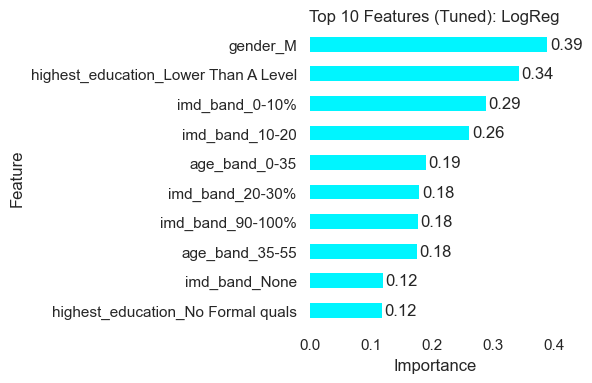

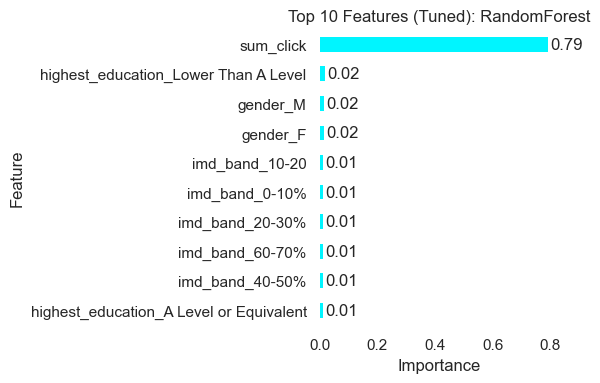

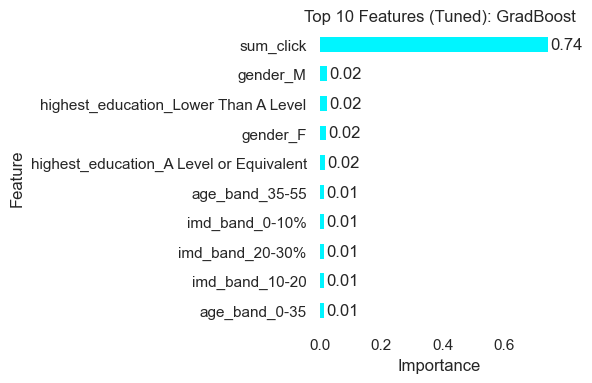

In [14]:
ohe_feature_names = []
for col, cats in zip(cat_cols, ohe.categories_):
    ohe_feature_names += [f"{col}_{c}" for c in cats]
feature_names = ohe_feature_names + [num_col]

feat_imports_tuned = {}
for name, clf in best_models.items():
    if hasattr(clf, 'coef_'):
        imps = np.mean(np.abs(clf.coef_), axis=0)
    else:
        imps = clf.feature_importances_
    feat_imports_tuned[name] = (
        pd.Series(imps, index=feature_names)
          .sort_values(ascending=False)
          .head(10)
    )

for name, impser in feat_imports_tuned.items():
    plt.figure(figsize=(6,4))
    ax = impser.plot(
        kind='barh',
        color='#00F5FF',
        edgecolor='none'
    )
    ax.invert_yaxis()
    ax.set_title(f'Top 10 Features (Tuned): {name}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')
    ax.grid(False)
    ax.set_facecolor('white')
    for spine in ['top','right','left','bottom']:
        ax.spines[spine].set_visible(False)
    max_imp = impser.max()
    for i, v in enumerate(impser):
        ax.text(v + max_imp*0.01, i, f"{v:.2f}", va='center', ha='left')
    plt.tight_layout()
    plt.show()


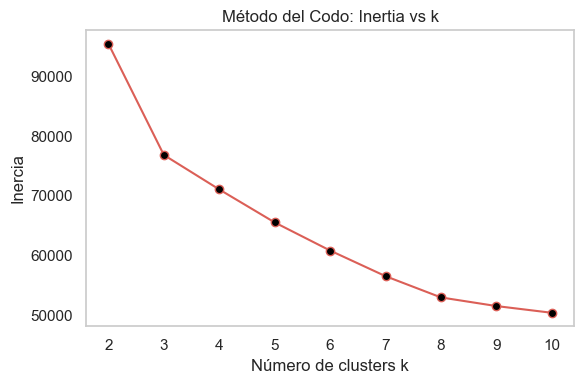

cluster
0     6069
1     9481
2    13705
3     3338
Name: count, dtype: int64

Centros de cluster (valores medios de cada feature):
   highest_education_A Level or Equivalent  \
0                            -1.609823e-15   
1                             7.110290e-01   
2                             4.310420e-01   
3                             4.188341e-01   

   highest_education_HE Qualification  highest_education_Lower Than A Level  \
0                        9.159340e-16                          1.000000e+00   
1                        2.561478e-01                         -6.994405e-15   
2                        1.158786e-01                          4.333771e-01   
3                        2.137519e-01                          3.437967e-01   

   highest_education_No Formal quals  \
0                      -1.110223e-16   
1                       1.329815e-02   
2                       1.444834e-02   
3                       6.875934e-03   

   highest_education_Post Graduate Quali

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

df_vle_agg = (
    student_vle
      .groupby(['code_module','code_presentation','id_student'])['sum_click']
      .sum()
      .reset_index()
)

df = pd.merge(
    student_info,
    df_vle_agg,
    on=['code_module','code_presentation','id_student'],
    how='left'
)
df['sum_click'] = df['sum_click'].fillna(0)

cat_cols = ['highest_education','imd_band','age_band','gender']
num_col  = 'sum_click'

X_cat = df[cat_cols]
X_num = df[[num_col]]

preproc = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

X_cat_enc = preproc.named_steps['ohe'].fit_transform(X_cat)
scaler = StandardScaler()
X_num_s = scaler.fit_transform(X_num)
X = np.hstack([X_cat_enc, X_num_s])

inertias = []
Ks = range(2,11)
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, 'o-', markerfacecolor='black')
plt.title('Método del Codo: Inertia vs k')
plt.xlabel('Número de clusters k')
plt.ylabel('Inercia')
plt.xticks(Ks)
plt.grid(False)
plt.tight_layout()
plt.show()

k_opt = 4

kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(X)

df['cluster'] = clusters

print(df['cluster'].value_counts().sort_index())


centers = kmeans.cluster_centers_
ohe = preproc.named_steps['ohe']
feat_names = list(ohe.get_feature_names_out(cat_cols)) + [num_col]

centers_df = pd.DataFrame(centers, columns=feat_names)
print("\nCentros de cluster (valores medios de cada feature):")
print(centers_df)

for i in range(k_opt):
    print(f"\n--- Cluster {i} ---")
    print(df[df['cluster']==i][cat_cols + [num_col]].describe())


C:\Users\artla\AppData\Local\Temp\ipykernel_23840\913012752.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_clusters))


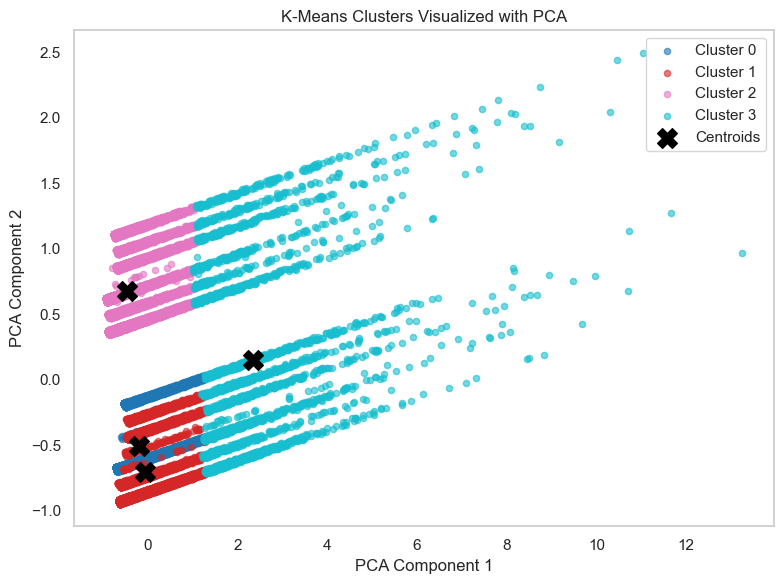

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
centers_pca = pca.transform(kmeans.cluster_centers_)
unique_clusters = np.unique(clusters)
colors = plt.cm.get_cmap('tab10', len(unique_clusters))

plt.figure(figsize=(8,6))
for idx, cluster in enumerate(unique_clusters):
    mask = clusters == cluster
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=20,
        color=colors(idx),
        label=f'Cluster {cluster}',
        alpha=0.6
    )

plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    s=200,
    color='black',
    marker='X',
    label='Centroids'
)

plt.title('K-Means Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()